In [8]:
import numpy as np
a=np.array([1,2,3])
np.unique(a).tolist() == [1, 2]

False

In [9]:
import numpy as np
from glob import glob
from tqdm import tqdm
import h5py
import nrrd
import os
import pandas as pd
from dataset_split import remove_files
import SimpleITK as sitk
from skimage import transform
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [10]:
output_size =[128, 128, 64]
old_space = []
counter_label = []
def resample_image3D(
    image3D,
    newspacing=[1.0,1.0,1.0],
    newsize=None,
    method='Linear',):
    """做插值"""
    resample = sitk.ResampleImageFilter()
    if method == 'Linear':
        resample.SetInterpolator(sitk.sitkLinear)
    elif method == 'Nearest':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    resample.SetOutputDirection(image3D.GetDirection())
    resample.SetOutputOrigin(image3D.GetOrigin())
    resample.SetOutputSpacing(newspacing)

    if not newsize:
        newsize = np.round(np.array(image3D.GetSize())*np.abs(image3D.GetSpacing())/np.array(newspacing)).astype('int').tolist()

    resample.SetSize(newsize)
    # resample.SetDefaultPixelValue(0)

    newimage = resample.Execute(image3D)
    return newimage


def sitk_onehot_transform(image):
    image_array = sitk.GetArrayFromImage(image)
    label_array_onehot = to_categorical(image_array)
    image_onehot = sitk.GetImageFromArray(label_array_onehot)
    image_onehot.SetOrigin(image.GetOrigin())
    image_onehot.SetDirection(image.GetDirection())
    image_onehot.SetSpacing(image.GetSpacing())
    return image_onehot

# 数组替换元素
def array_replace(array,olds,news):
    # 不适用于onehot
    #olds:list of old value
    #news:list of new value
    olds = np.array(olds)
    news = np.array(news)
    offset = olds.max()*10
    tmps = olds+offset
    array += offset
    for tmp,new in zip(tmps,news):
        array[array==tmp] = new
    return array


def make_out_itk(image,image_sitk):
    out_image_sitk = sitk.GetImageFromArray(image)
    out_image_sitk.SetSpacing(image_sitk.GetSpacing())
    out_image_sitk.SetOrigin(image_sitk.GetOrigin())
    out_image_sitk.SetDirection(image_sitk.GetDirection())
    return out_image_sitk

def covert_h5(glob_str, old_replaced, new_replaced):
    """
    备注：不要骨头，骨头合并到背景类别中
    """
    listt = glob(glob_str)
    error_samples = []
    error_samples_origin = []
    '''stats = pd.DataFrame(columns=['sample_name',
                                  'mean_whole', 
                                  'mean_bg', 
                                  'mean_dura', 
                                  'mean_SC', 
                                  'std_whole',
                                  'std_bg',
                                  'std_dura',
                                  'std_SC',
                                  'old_space0','old_space1','old_space2',
                                  'new_space0','new_space1','new_space2',
                                 ])'''
    for item in tqdm(listt):
        sample_name = item.split('/')[-2]
        print(sample_name,':')#win系统改为'\\'
#         if not sample_name == "1171704-neck":#B809338":#""1352900":#B809338":#"1756747":#1700637-neck":
#             continue
        
        # read image
        print("item: ",item)
        image = sitk.ReadImage(item)
        seg = sitk.ReadImage(item.replace(old_replaced, 'Segmentation.seg.nrrd'))
        label = sitk.ReadImage(item.replace(old_replaced, 'Segmentation-label.nrrd'))
        label_onehot = sitk_onehot_transform(label)
        
        
        label_name = [
            'bg',
            seg.GetMetaData('Segment0_Name'),
            seg.GetMetaData('Segment1_Name'),
            seg.GetMetaData('Segment2_Name') 
            ]#人工标注的类别顺序
        oldspacing = np.abs(image.GetSpacing())
        old_space.append(oldspacing)
        print('oldspacing: ',oldspacing)
        newspacing = [1.0, 1.0, 1.0]

        # resample/rescale( by sitk )
        image = resample_image3D(image,newspacing,method='Linear')
        label_onehot = resample_image3D(label_onehot,newspacing,method='Nearest')
        
        # get array
        image = sitk.GetArrayFromImage(image).transpose((2,1,0))#tanspose之后才能与sizes匹配
        label_onehot = np.round( sitk.GetArrayFromImage(label_onehot) ).transpose((2,1,0,3))#tanspose之后才能与sizes匹配
        label = np.argmax(label_onehot,axis=-1)
        #label_temp = label.flatten()
        #print(Counter(label_temp))
        plot_slice_sample(image,label,np.nonzero(label)[2].max(),item.replace(old_replaced,'slice_sample_origin.png'))
        
        
        if not image.shape == label_onehot.shape[:-1]:
            error_samples.append(sample_name)
            print("error sample(mismatch shape of image and label):",sample_name)
            continue

        if not label_onehot.sum(axis=-1).max()==1:
            # label onehot encoder可以解决这个问题
            error_samples.append(sample_name)
            print("error sample(some pixels in seg are multi-category at the same time):",sample_name)
            continue
        
        # 灰度标准化
        image = (image - np.mean(image)) / np.std(image)
        image = image.astype(np.float32)

        
        # 错误病例：标记的尺寸和image尺寸不同，缺少其中一个类别或者多个类别的标记
        if not label_onehot.shape[-1] == 4:
            error_samples.append(sample_name)
            print("error sample(no df/pf/fra):",sample_name)
            continue 
        if not (np.unique(label_onehot) == [0, 1]).all():
            error_samples.append(sample_name)
            print("error sample label file error:",sample_name)   
            continue
        
        ## 调整类别顺序&合并骨头到背景中，注意：是onehot编码
        target_name = ['bg','proximal femur','distal femur','fragment']#目标类别顺序
        idx = [label_name.index(name) for name in target_name]
        assert len(idx)==4,'one or more classes missed'
        label_onehot = label_onehot[:,:,:,idx]

        '''## bone归入背景类
        bg = label_onehot[:,:,:,[0,1]].sum(axis=-1)[:,:,:,np.newaxis]
        label_onehot = np.concatenate((bg,label_onehot[:,:,:,2:]),axis=-1)
        assert (np.unique(label_onehot) == [0, 1]).all(), "1: pixel class error"
        ## 转化为非onehot编码以便作图'''
        label = np.argmax(label_onehot, axis=-1)
        
        # cut( random center cut)
        tempL = np.nonzero(label)
        minx, maxx = np.min(tempL[0]), np.max(tempL[0])
        miny, maxy = np.min(tempL[1]), np.max(tempL[1])
        minz, maxz = np.min(tempL[2]), np.max(tempL[2])
        w, h, d = label.shape
        px = max(output_size[0] - (maxx-minx+1), 0) // 2
        py = max(output_size[1] - (maxy-miny+1), 0) // 2
        #pz = max(output_size[2] - (maxz-minz+1), 0) // 2
        minx = max(minx - np.random.randint(10, 20) - px, 0)
        maxx = min(maxx + np.random.randint(10, 20) + px, w-1)
        miny = max(miny - np.random.randint(10, 20) - py, 0)
        maxy = min(maxy + np.random.randint(10, 20) + py, h-1)
        #minz = max(minz - np.random.randint(10, 20) - pz, 0)
        #maxz = min(maxz + np.random.randint(10, 20) + pz, d)
        image = image[minx:maxx+1, miny:maxy+1, minz:maxz+1]
        label = label[minx:maxx+1, miny:maxy+1, minz:maxz+1]
        label_onehot = label_onehot[minx:maxx+1, miny:maxy+1, minz:maxz+1, :]
        print("cut image.shape:",image.shape, "cut label.shape:",label.shape)
        #plot_slice_sample(image,label,maxz-minz,item.replace(old_replaced,'slice_sample.png'))
        print("minx: ",minx, "maxx: ",maxx)
        print("index: ",int((maxx-minx)/2))
        plot_slice_sample(image,label,int((maxx-minx)/2),item.replace(old_replaced,'slice_sample.png'))
        
        # save files
        f = h5py.File(item.replace(old_replaced, new_replaced), 'w')
        f.create_dataset('image', data=image, compression="gzip")
        f.create_dataset('label', data=label_onehot, compression="gzip")
        f.close()
    print("total number of samples:", len(listt))
    return error_samples, error_samples_origin

def plot_slice_sample(image,label,d,fn):
    fig = plt.figure()
    a = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(image[d,:,:].squeeze())
    a.set_title('image')
    plt.colorbar(orientation='horizontal')
    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(label[d,:,:].squeeze())
    imgplot.set_clim(0.0, 3.0)
    a.set_title('label')
    plt.colorbar(orientation='horizontal')
    plt.savefig(fn)
    plt.show()
    
def covert_h5_unseg(glob_str, old_replaced, new_replaced):
    """
    备注：无标注数据的格式转换
    """
    listt = glob(glob_str)
    for item in tqdm(listt):
        sample_name = item.split('/')[-2]
        print("item: ", item)
        print("sample_name: ",sample_name)
        print(sample_name,':')#win系统改为'\\'
        
        image = sitk.ReadImage(item)
        
        # resample
        newspacing = [1.0, 1.0, 1.0]
        image = resample_image3D(image,newspacing,method='Linear')
        image = sitk.GetArrayFromImage(image).transpose((2,1,0))#tanspose之后才能与sizes匹配
        
        # 灰度标准化
        image = (image - np.mean(image)) / np.std(image)
        image = image.astype(np.float32)
        print("image shape:",image.shape)
        
        f = h5py.File(item.replace(old_replaced, new_replaced), 'w')
        f.create_dataset('image', data=image, compression="gzip")
        f.close() 
    print("total number of unseg-samples:", len(listt))


In [13]:
print('unseg dataset:')
## 先删除旧文件
dataset_dir = '../../../data/gz_dataset/unsegmented/DF-CT'
re = os.path.join(dataset_dir,'*/mri_norm2.h5')
remove_files(re=re)
## 再生成新文件
glob_str = '../../../data/gz_dataset/unsegmented/DF-CT/*/CT.nrrd'
covert_h5_unseg(glob_str,'CT.nrrd','mri_norm2.h5')
#glob_str = '../../data/CTM_dataset/unSegmented/*/CT-vol.nrrd'
#covert_h5_unseg(glob_str,'CT-vol.nrrd','mri_norm2.h5')  



  0%|          | 0/12 [00:00<?, ?it/s]

unseg dataset:
item:  ../../../data/gz_dataset/unsegmented/DF-CT/171247/CT.nrrd
sample_name:  171247
171247 :
image shape: (418, 418, 183)




  8%|▊         | 1/12 [00:04<00:53,  4.87s/it]

item:  ../../../data/gz_dataset/unsegmented/DF-CT/174219/CT.nrrd
sample_name:  174219
174219 :
image shape: (400, 400, 275)




 17%|█▋        | 2/12 [00:12<00:56,  5.61s/it]

item:  ../../../data/gz_dataset/unsegmented/DF-CT/180200/CT.nrrd
sample_name:  180200
180200 :
image shape: (447, 447, 205)




 25%|██▌       | 3/12 [00:18<00:51,  5.69s/it]

item:  ../../../data/gz_dataset/unsegmented/DF-CT/182503/CT.nrrd
sample_name:  182503
182503 :
image shape: (402, 402, 251)




 33%|███▎      | 4/12 [00:24<00:47,  5.89s/it]

item:  ../../../data/gz_dataset/unsegmented/DF-CT/184647/CT.nrrd
sample_name:  184647
184647 :
image shape: (264, 264, 279)




 42%|████▏     | 5/12 [00:28<00:37,  5.33s/it]

item:  ../../../data/gz_dataset/unsegmented/DF-CT/190409/CT.nrrd
sample_name:  190409
190409 :
image shape: (201, 201, 491)




 50%|█████     | 6/12 [00:33<00:31,  5.32s/it]

item:  ../../../data/gz_dataset/unsegmented/DF-CT/200617/CT.nrrd
sample_name:  200617
200617 :
image shape: (264, 264, 479)




 58%|█████▊    | 7/12 [00:40<00:28,  5.61s/it]

item:  ../../../data/gz_dataset/unsegmented/DF-CT/201154/CT.nrrd
sample_name:  201154
201154 :
image shape: (400, 400, 597)




 67%|██████▋   | 8/12 [00:53<00:31,  7.99s/it]

item:  ../../../data/gz_dataset/unsegmented/DF-CT/205211/CT.nrrd
sample_name:  205211
205211 :
image shape: (379, 379, 183)




 75%|███████▌  | 9/12 [00:57<00:20,  6.83s/it]

item:  ../../../data/gz_dataset/unsegmented/DF-CT/221205/CT.nrrd
sample_name:  221205
221205 :
image shape: (412, 412, 235)




 83%|████████▎ | 10/12 [01:07<00:15,  7.73s/it]

item:  ../../../data/gz_dataset/unsegmented/DF-CT/223849/CT.nrrd
sample_name:  223849
223849 :
image shape: (279, 279, 241)




 92%|█████████▏| 11/12 [01:11<00:06,  6.51s/it]

item:  ../../../data/gz_dataset/unsegmented/DF-CT/233937/CT.nrrd
sample_name:  233937
233937 :
image shape: (316, 316, 214)




100%|██████████| 12/12 [01:15<00:00,  6.25s/it]

total number of unseg-samples: 12


In [16]:
from dataset_split import dataset_split, make_dataset_list
dataset_dir = '../../../data/gz_dataset/unsegmented/success'
save_dir = '../../../data/gz_dataset'
make_dataset_list(path=dataset_dir,save_dir=save_dir)

seg dataset:











  0%|          | 0/40 [00:00<?, ?it/s]

100043176 :
item:  ../../../data/gz_dataset/segmented/100043176/CT.nrrd
oldspacing:  [0.45703125 0.45703125 1.00000001]


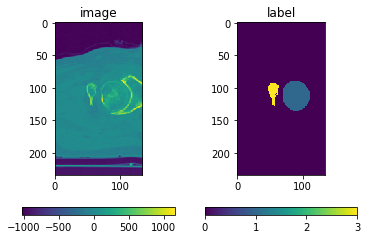

cut image.shape: (150, 155, 112) cut label.shape: (150, 155, 112)
minx:  58 maxx:  207
index:  74


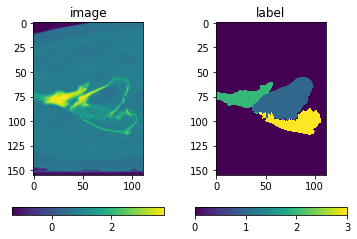










  2%|▎         | 1/40 [00:07<05:04,  7.81s/it]

100067245 :
item:  ../../../data/gz_dataset/segmented/100067245/CT.nrrd
oldspacing:  [0.35351563 0.35351563 1.        ]


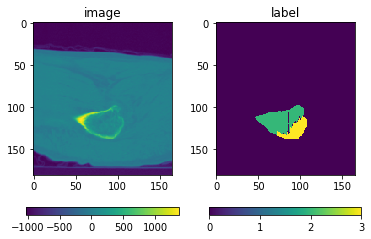

cut image.shape: (149, 141, 133) cut label.shape: (149, 141, 133)
minx:  32 maxx:  180
index:  74


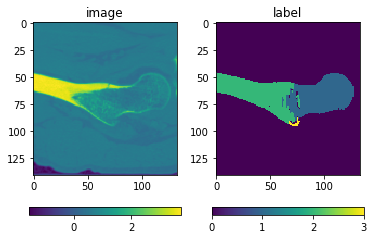










  5%|▌         | 2/40 [00:15<04:56,  7.81s/it]

100067436 :
item:  ../../../data/gz_dataset/segmented/100067436/CT.nrrd
oldspacing:  [0.45507812 0.45507812 1.        ]


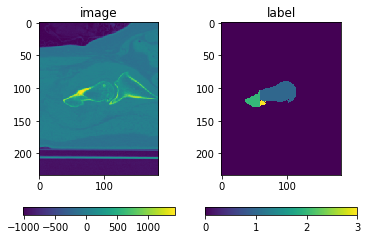

cut image.shape: (164, 163, 120) cut label.shape: (164, 163, 120)
minx:  43 maxx:  206
index:  81


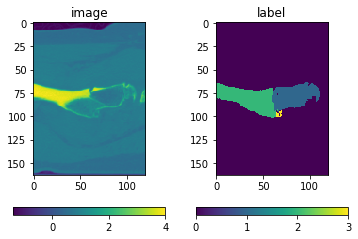










  8%|▊         | 3/40 [00:25<05:08,  8.35s/it]

100109304 :
item:  ../../../data/gz_dataset/segmented/100109304/CT.nrrd
oldspacing:  [0.4140625 0.4140625 1.       ]


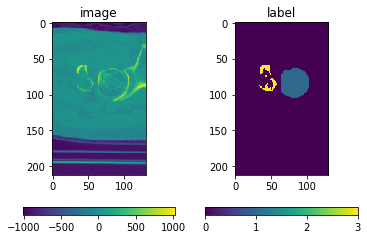

cut image.shape: (154, 154, 105) cut label.shape: (154, 154, 105)
minx:  20 maxx:  173
index:  76


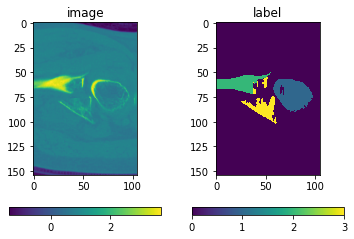










 10%|█         | 4/40 [00:32<04:46,  7.95s/it]

100126291 :
item:  ../../../data/gz_dataset/segmented/100126291/CT.nrrd
oldspacing:  [0.50390625 0.50390625 1.        ]


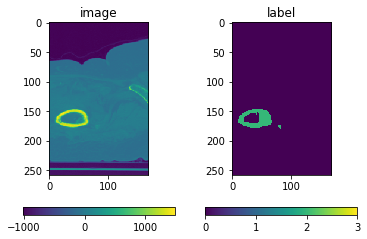

cut image.shape: (157, 149, 109) cut label.shape: (157, 149, 109)
minx:  42 maxx:  198
index:  78


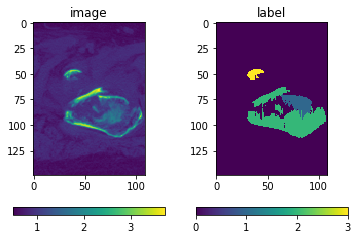










 12%|█▎        | 5/40 [00:41<04:53,  8.39s/it]

100201344 :
item:  ../../../data/gz_dataset/segmented/100201344/CT.nrrd
oldspacing:  [0.447266 0.447266 1.25    ]


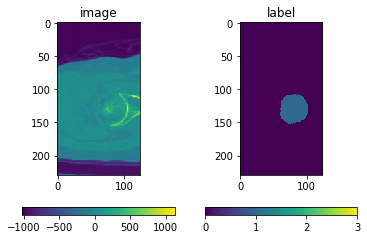

cut image.shape: (156, 155, 109) cut label.shape: (156, 155, 109)
minx:  55 maxx:  210
index:  77


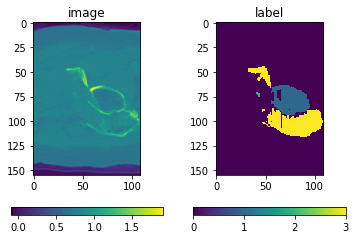










 15%|█▌        | 6/40 [00:48<04:30,  7.95s/it]

100207091 :
item:  ../../../data/gz_dataset/segmented/100207091/CT.nrrd
oldspacing:  [0.46484375 0.46484375 1.        ]


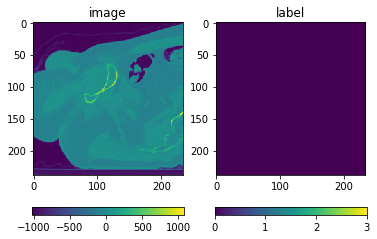

cut image.shape: (160, 156, 173) cut label.shape: (160, 156, 173)
minx:  7 maxx:  166
index:  79


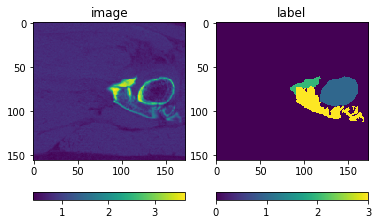










 18%|█▊        | 7/40 [01:00<05:00,  9.10s/it]

100218737 :
item:  ../../../data/gz_dataset/segmented/100218737/CT.nrrd
oldspacing:  [0.36523437 0.36523437 1.        ]


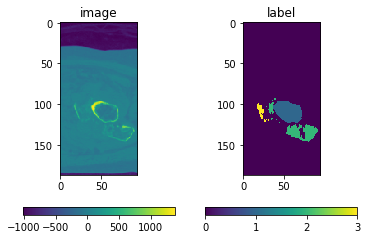

cut image.shape: (155, 155, 91) cut label.shape: (155, 155, 91)
minx:  19 maxx:  173
index:  77


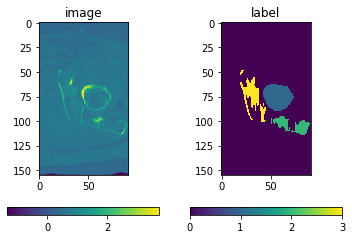










 20%|██        | 8/40 [01:05<04:17,  8.05s/it]

100301649 :
item:  ../../../data/gz_dataset/segmented/100301649/CT.nrrd
oldspacing:  [0.392578 0.392578 1.25    ]


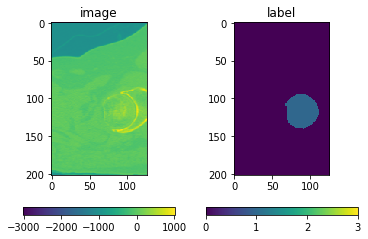

cut image.shape: (159, 147, 111) cut label.shape: (159, 147, 111)
minx:  1 maxx:  159
index:  79


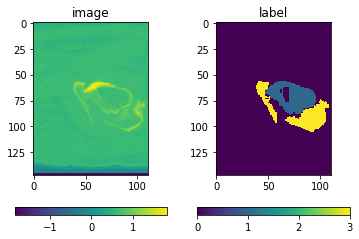










 22%|██▎       | 9/40 [01:12<03:54,  7.57s/it]

100363286 :
item:  ../../../data/gz_dataset/segmented/100363286/CT.nrrd
oldspacing:  [0.392578 0.392578 1.25    ]


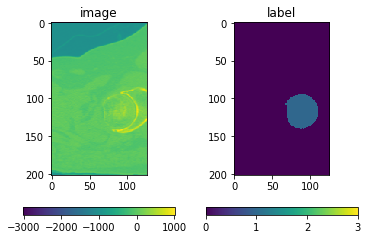

cut image.shape: (153, 156, 111) cut label.shape: (153, 156, 111)
minx:  8 maxx:  160
index:  76


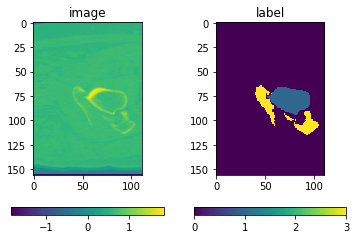










 25%|██▌       | 10/40 [01:18<03:36,  7.22s/it]

100365675 :
item:  ../../../data/gz_dataset/segmented/100365675/CT.nrrd
oldspacing:  [0.45117188 0.45117188 1.        ]


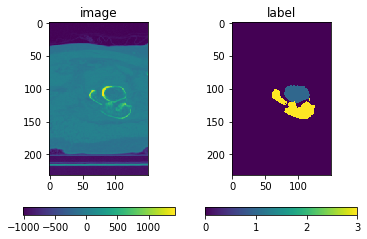

cut image.shape: (152, 150, 129) cut label.shape: (152, 150, 129)
minx:  50 maxx:  201
index:  75


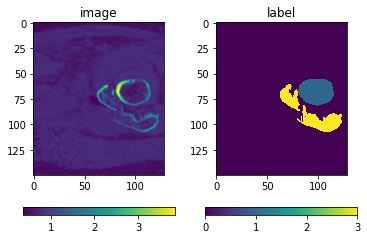










 28%|██▊       | 11/40 [01:27<03:40,  7.60s/it]

100468900 :
item:  ../../../data/gz_dataset/segmented/100468900/CT.nrrd
oldspacing:  [0.44921875 0.44921875 1.        ]


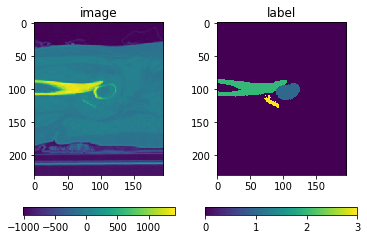

cut image.shape: (155, 155, 139) cut label.shape: (155, 155, 139)
minx:  62 maxx:  216
index:  77


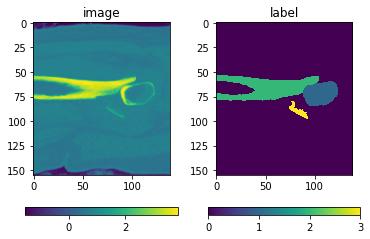










 30%|███       | 12/40 [01:37<03:51,  8.28s/it]

100511557 :
item:  ../../../data/gz_dataset/segmented/100511557/CT.nrrd
oldspacing:  [0.43164063 0.43164063 0.99999998]


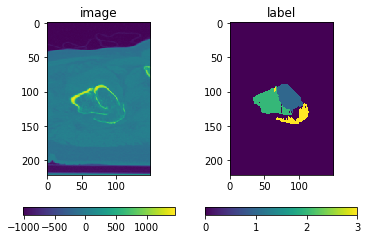

cut image.shape: (161, 158, 114) cut label.shape: (161, 158, 114)
minx:  41 maxx:  201
index:  80


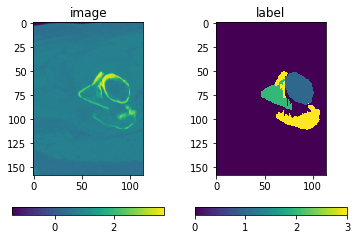










 32%|███▎      | 13/40 [01:45<03:42,  8.26s/it]

100589263 :
item:  ../../../data/gz_dataset/segmented/100589263/CT.nrrd
oldspacing:  [0.47460938 0.47460938 1.        ]


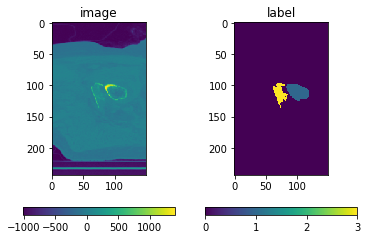

cut image.shape: (155, 158, 131) cut label.shape: (155, 158, 131)
minx:  51 maxx:  205
index:  77


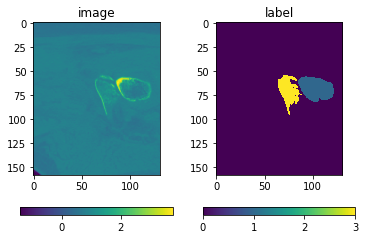










 35%|███▌      | 14/40 [01:54<03:39,  8.44s/it]

100658440 :
item:  ../../../data/gz_dataset/segmented/100658440/CT.nrrd
oldspacing:  [0.505859 0.505859 1.25    ]


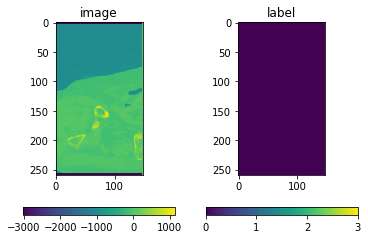

cut image.shape: (153, 152, 101) cut label.shape: (153, 152, 101)
minx:  81 maxx:  233
index:  76


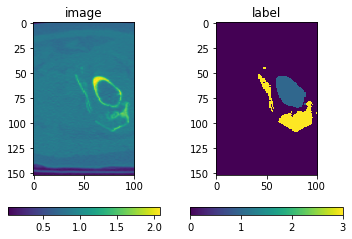










 38%|███▊      | 15/40 [02:02<03:29,  8.39s/it]

100752370 :
item:  ../../../data/gz_dataset/segmented/100752370/CT.nrrd
oldspacing:  [0.44726563 0.44726563 1.        ]


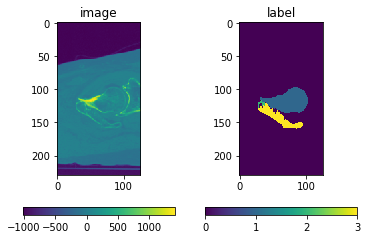

cut image.shape: (155, 164, 104) cut label.shape: (155, 164, 104)
minx:  23 maxx:  177
index:  77


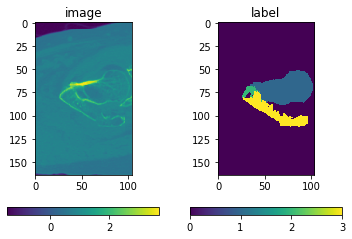










 40%|████      | 16/40 [02:10<03:15,  8.14s/it]

100866034 :
item:  ../../../data/gz_dataset/segmented/100866034/CT.nrrd
oldspacing:  [0.46875 0.46875 1.5    ]


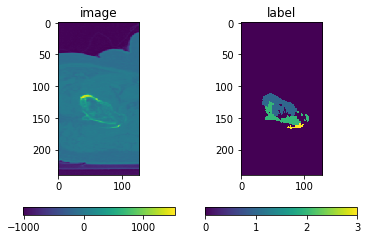

cut image.shape: (159, 150, 108) cut label.shape: (159, 150, 108)
minx:  37 maxx:  195
index:  79


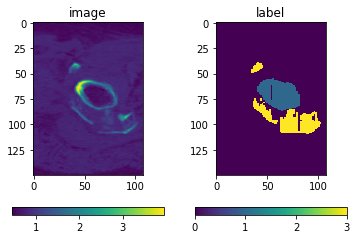










 42%|████▎     | 17/40 [02:16<02:55,  7.64s/it]

100903938 :
item:  ../../../data/gz_dataset/segmented/100903938/CT.nrrd
oldspacing:  [0.433594 0.433594 1.25    ]


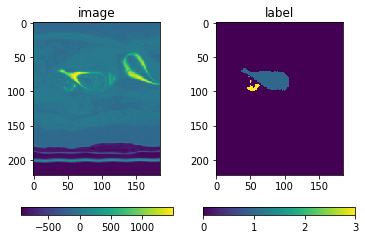

cut image.shape: (154, 155, 112) cut label.shape: (154, 155, 112)
minx:  41 maxx:  194
index:  76


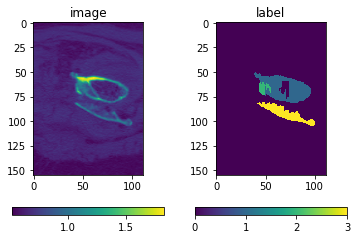










 45%|████▌     | 18/40 [02:24<02:52,  7.85s/it]

100904166 :
item:  ../../../data/gz_dataset/segmented/100904166/CT.nrrd
oldspacing:  [0.49609375 0.49609375 1.        ]


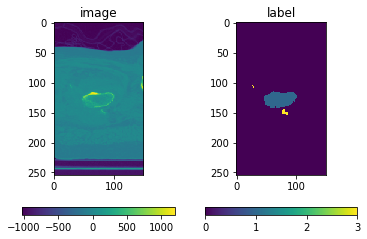

cut image.shape: (161, 152, 117) cut label.shape: (161, 152, 117)
minx:  35 maxx:  195
index:  80


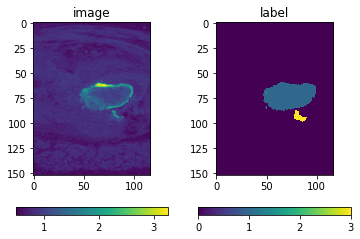










 48%|████▊     | 19/40 [02:33<02:50,  8.10s/it]

100966703 :
item:  ../../../data/gz_dataset/segmented/100966703/CT.nrrd
oldspacing:  [0.505859 0.505859 1.25    ]


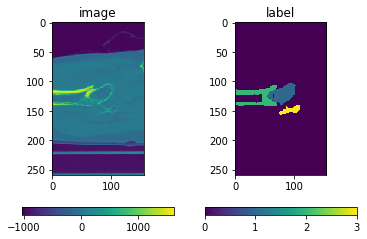

cut image.shape: (157, 160, 120) cut label.shape: (157, 160, 120)
minx:  48 maxx:  204
index:  78


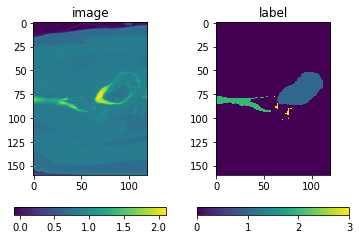










 50%|█████     | 20/40 [02:42<02:46,  8.33s/it]

100973211 :
item:  ../../../data/gz_dataset/segmented/100973211/CT.nrrd
oldspacing:  [0.4296875  0.4296875  0.99999999]


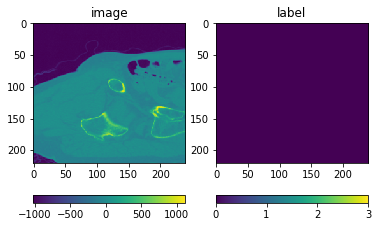

cut image.shape: (156, 157, 170) cut label.shape: (156, 157, 170)
minx:  31 maxx:  186
index:  77


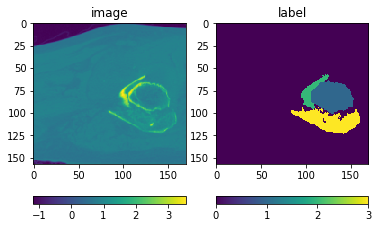










 52%|█████▎    | 21/40 [02:53<02:56,  9.27s/it]

101037694 :
item:  ../../../data/gz_dataset/segmented/101037694/CT.nrrd
oldspacing:  [0.47851562 0.47851562 1.5       ]


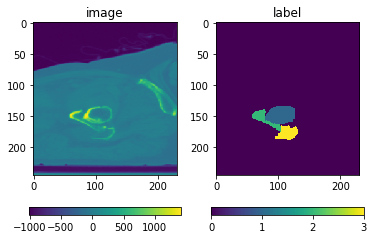

cut image.shape: (158, 161, 135) cut label.shape: (158, 161, 135)
minx:  53 maxx:  210
index:  78


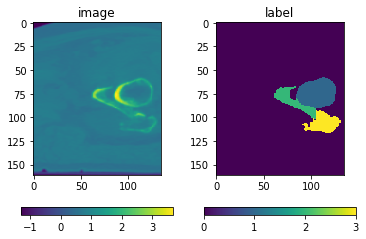










 55%|█████▌    | 22/40 [03:04<02:54,  9.67s/it]

101123360 :
item:  ../../../data/gz_dataset/segmented/101123360/CT.nrrd
oldspacing:  [0.38476562 0.38476562 1.5       ]


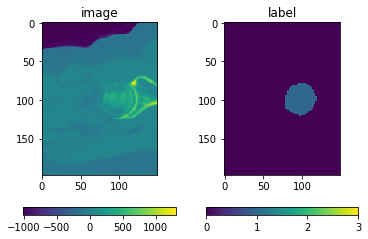

cut image.shape: (156, 156, 120) cut label.shape: (156, 156, 120)
minx:  17 maxx:  172
index:  77


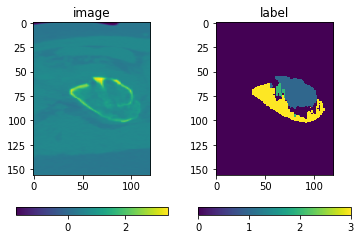










 57%|█████▊    | 23/40 [03:11<02:30,  8.83s/it]

101135074 :
item:  ../../../data/gz_dataset/segmented/101135074/CT.nrrd
oldspacing:  [0.41015625 0.41015625 1.        ]


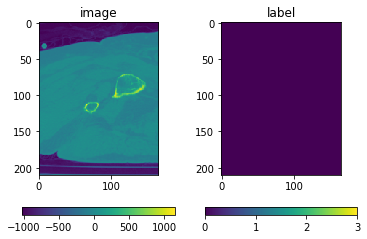

cut image.shape: (158, 155, 141) cut label.shape: (158, 155, 141)
minx:  15 maxx:  172
index:  78


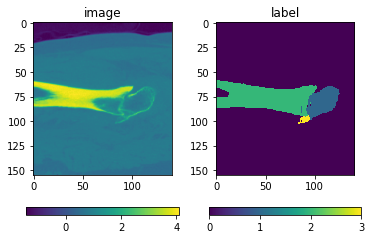










 60%|██████    | 24/40 [03:19<02:19,  8.70s/it]

101195715 :
item:  ../../../data/gz_dataset/segmented/101195715/CT.nrrd
oldspacing:  [0.55078125 0.55078125 1.        ]


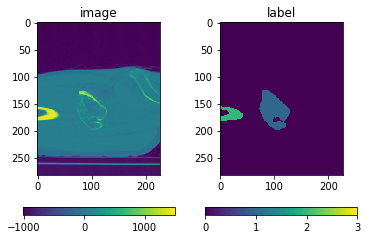

cut image.shape: (153, 154, 152) cut label.shape: (153, 154, 152)
minx:  74 maxx:  226
index:  76


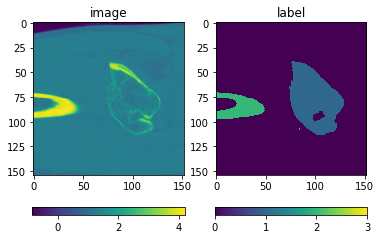










 62%|██████▎   | 25/40 [03:32<02:29,  9.99s/it]

101235096 :
item:  ../../../data/gz_dataset/segmented/101235096/CT.nrrd
oldspacing:  [0.55664062 0.55664062 1.        ]


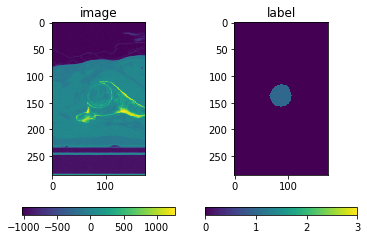

cut image.shape: (160, 155, 113) cut label.shape: (160, 155, 113)
minx:  67 maxx:  226
index:  79


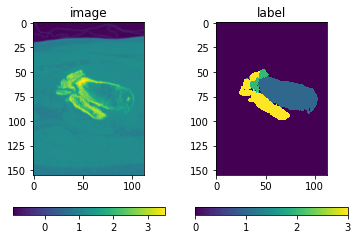










 65%|██████▌   | 26/40 [03:43<02:23, 10.26s/it]

101244281 :
item:  ../../../data/gz_dataset/segmented/101244281/CT.nrrd
oldspacing:  [0.43164062 0.43164062 0.6       ]


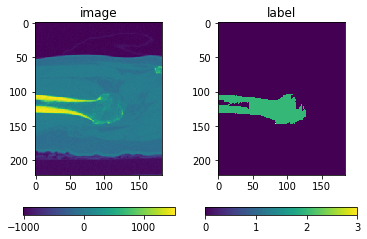

cut image.shape: (163, 155, 143) cut label.shape: (163, 155, 143)
minx:  34 maxx:  196
index:  81


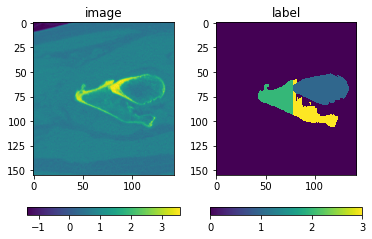










 68%|██████▊   | 27/40 [03:54<02:17, 10.56s/it]

101270489 :
item:  ../../../data/gz_dataset/segmented/101270489/CT.nrrd
oldspacing:  [0.50390625 0.50390625 1.        ]


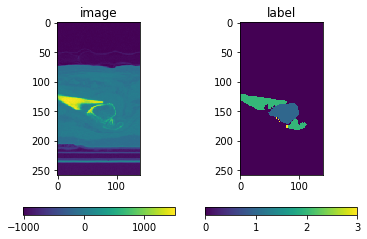

cut image.shape: (151, 154, 118) cut label.shape: (151, 154, 118)
minx:  51 maxx:  201
index:  75


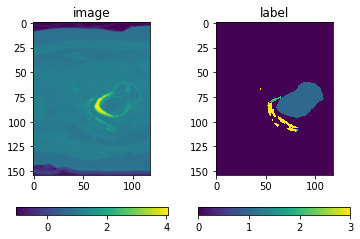










 70%|███████   | 28/40 [04:03<01:58,  9.88s/it]

101272793 :
item:  ../../../data/gz_dataset/segmented/101272793/CT.nrrd
oldspacing:  [0.40429688 0.40429688 1.        ]


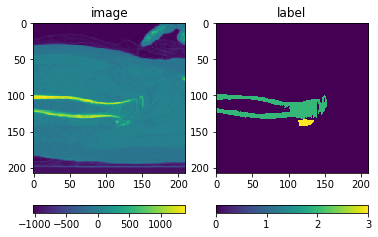

cut image.shape: (161, 165, 155) cut label.shape: (161, 165, 155)
minx:  43 maxx:  203
index:  80


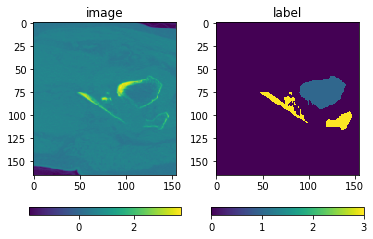










 72%|███████▎  | 29/40 [04:13<01:51, 10.13s/it]

101283210 :
item:  ../../../data/gz_dataset/segmented/101283210/CT.nrrd
oldspacing:  [0.45117188 0.45117188 1.        ]


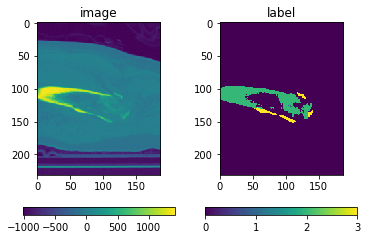

cut image.shape: (157, 159, 148) cut label.shape: (157, 159, 148)
minx:  48 maxx:  204
index:  78


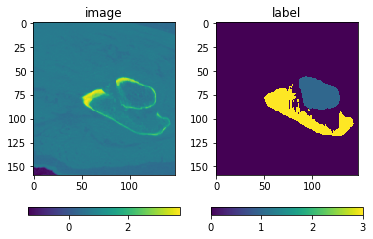










 75%|███████▌  | 30/40 [04:25<01:46, 10.70s/it]

101503000 :
item:  ../../../data/gz_dataset/segmented/101503000/CT.nrrd
oldspacing:  [0.449219 0.449219 1.25    ]


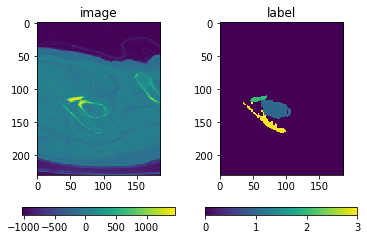

cut image.shape: (163, 157, 111) cut label.shape: (163, 157, 111)
minx:  36 maxx:  198
index:  81


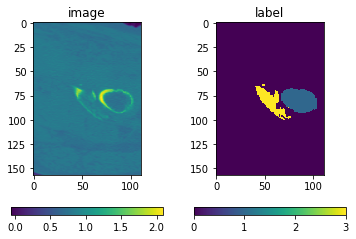










 78%|███████▊  | 31/40 [04:34<01:31, 10.14s/it]

101517690 :
item:  ../../../data/gz_dataset/segmented/101517690/CT.nrrd
oldspacing:  [0.46679687 0.46679687 1.19999993]


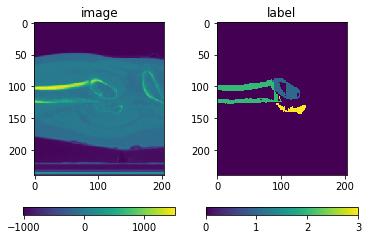

cut image.shape: (154, 156, 144) cut label.shape: (154, 156, 144)
minx:  59 maxx:  212
index:  76


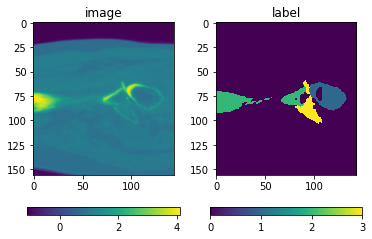










 80%|████████  | 32/40 [04:44<01:20, 10.10s/it]

101535491 :
item:  ../../../data/gz_dataset/segmented/101535491/CT.nrrd
oldspacing:  [0.41210937 0.41210937 1.        ]


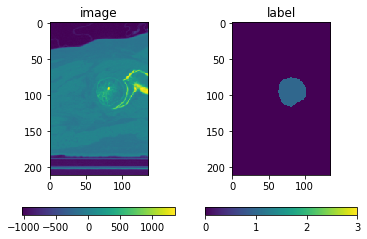

cut image.shape: (161, 156, 104) cut label.shape: (161, 156, 104)
minx:  37 maxx:  197
index:  80


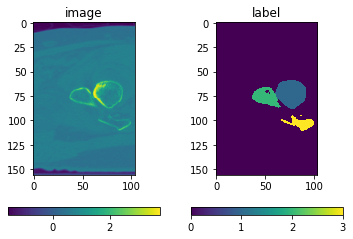










 82%|████████▎ | 33/40 [04:52<01:05,  9.31s/it]

101542030 :
item:  ../../../data/gz_dataset/segmented/101542030/CT.nrrd
oldspacing:  [0.50976562 0.50976562 1.        ]


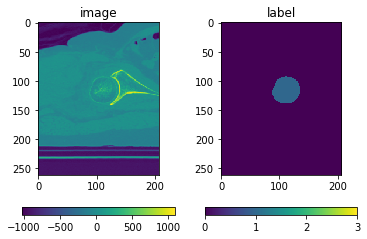

cut image.shape: (159, 156, 135) cut label.shape: (159, 156, 135)
minx:  25 maxx:  183
index:  79


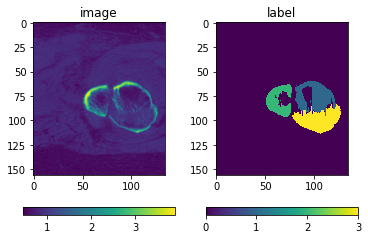










 85%|████████▌ | 34/40 [05:03<01:00, 10.02s/it]

101549387 :
item:  ../../../data/gz_dataset/segmented/101549387/CT.nrrd
oldspacing:  [0.47265625 0.47265625 1.        ]


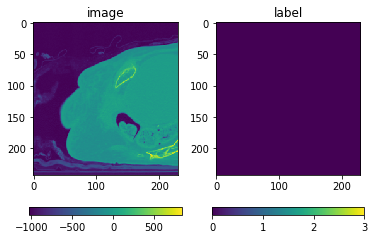

cut image.shape: (152, 157, 196) cut label.shape: (152, 157, 196)
minx:  17 maxx:  168
index:  75


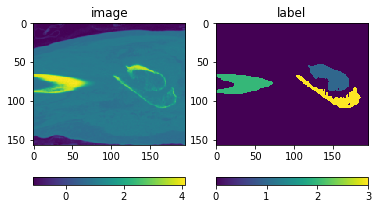










 88%|████████▊ | 35/40 [05:15<00:53, 10.61s/it]

101553537 :
item:  ../../../data/gz_dataset/segmented/101553537/CT.nrrd
oldspacing:  [0.43164062 0.43164062 1.        ]


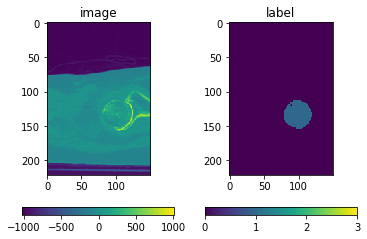

cut image.shape: (155, 152, 120) cut label.shape: (155, 152, 120)
minx:  20 maxx:  174
index:  77


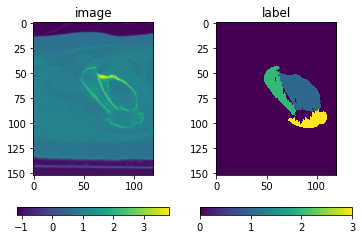










 90%|█████████ | 36/40 [05:24<00:39,  9.88s/it]

50010491 :
item:  ../../../data/gz_dataset/segmented/50010491/CT.nrrd
oldspacing:  [0.38867188 0.38867188 1.        ]


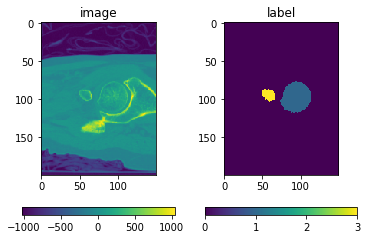

cut image.shape: (161, 152, 114) cut label.shape: (161, 152, 114)
minx:  18 maxx:  178
index:  80


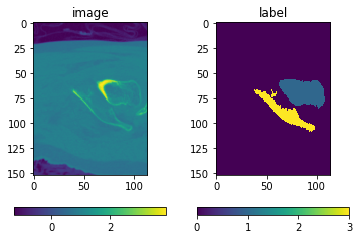










 92%|█████████▎| 37/40 [05:32<00:28,  9.38s/it]

50011422 :
item:  ../../../data/gz_dataset/segmented/50011422/CT.nrrd
oldspacing:  [0.50195312 0.50195312 1.        ]


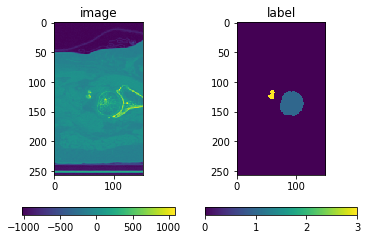

cut image.shape: (158, 148, 113) cut label.shape: (158, 148, 113)
minx:  55 maxx:  212
index:  78


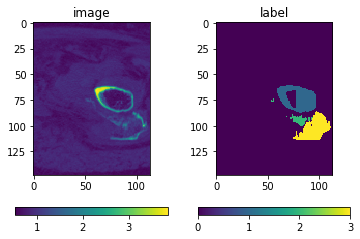










 95%|█████████▌| 38/40 [05:41<00:18,  9.24s/it]

50012263 :
item:  ../../../data/gz_dataset/segmented/50012263/CT.nrrd
oldspacing:  [0.55664062 0.55664062 2.00000095]


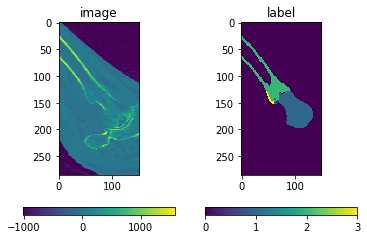

cut image.shape: (147, 205, 134) cut label.shape: (147, 205, 134)
minx:  49 maxx:  195
index:  73


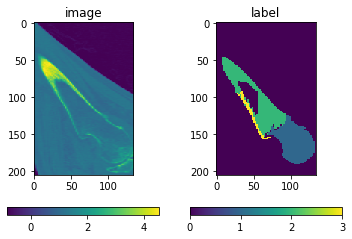










 98%|█████████▊| 39/40 [05:49<00:09,  9.06s/it]

50167203 :
item:  ../../../data/gz_dataset/segmented/50167203/CT.nrrd
oldspacing:  [0.51757812 0.51757812 1.        ]


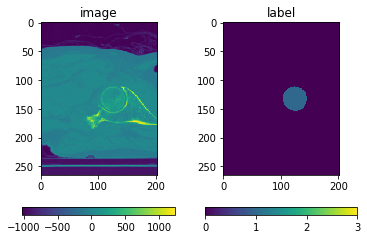

cut image.shape: (160, 160, 148) cut label.shape: (160, 160, 148)
minx:  35 maxx:  194
index:  79


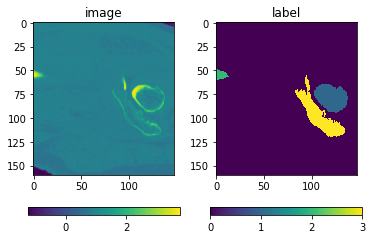










100%|██████████| 40/40 [06:01<00:00,  9.04s/it]

total number of samples: 40
[0.45546875 0.45546875 1.10125002]


In [60]:
print('seg dataset:')
## 先删除旧文件
dataset_dir = '../../../data/gz_dataset/segmented'
re = os.path.join(dataset_dir,'*/mri_norm2.h5')
remove_files(re=re)
## 再生成新文件
glob_str = '../../../data/gz_dataset/segmented/*/CT.nrrd'
error_samples,error_samples_origin = covert_h5(glob_str,'CT.nrrd','mri_norm2.h5')
old_space=np.array(old_space)
print(old_space.mean(axis=0))

    


In [14]:
from dataset_split import dataset_split, make_dataset_list
# 有标签数据(划分为两个数据集并生成列表)
save_dir = '../../../data/gz_dataset'
dataset_dir = '../../../data/gz_dataset/segmented'
list_train_validatioin,list_test = dataset_split(path=dataset_dir,save_dir=save_dir)